In [1]:
from collections import Counter

import pandas as pd
import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
import sklearn.tree
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number

In [3]:
def w(x):
    return np.int(hash(x)) % 1000


h = np.vectorize(w)

In [1]:
class TreeNode:
    def __init__(self, split_rule, left, right, label):
        self.left = left
        self.right = right
        self.label = label
        self.split_rule = split_rule
    
    def is_leaf(self):
        return self.label is not None
    
    def get_label(self, x):
        if self.is_leaf():
            return self.label
        else:
            idx = self.split_rule[0]
            thresh = self.split_rule[1]
            if x[idx] <= thresh:
                return self.left.get_label(x)
            else:
                return self.right.get_label(x)
    
    #Function which helps visualizing the tree
    def print2DUtil(self, root, space, feature_list=None):
        COUNT = [10]
        # Base case
        if (root == None) :
            return
        # Increase distance between levels
        space += COUNT[0]
        # Process right child first
        self.print2DUtil(root.right, space)
        # Print current node after space
        # count
        print()
        for i in range(COUNT[0], space):
            print(end = " ")
        if root.is_leaf():
            print(repr(['leaf',root.label]))
        else:
            print(repr(['node',root.split_rule]))
        # Process left child
        self.print2DUtil(root.left, space)
        
    def print2D(self,root):
        self.print2DUtil(root, 0)

In [6]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        # TODO implement __init__ function
        self.max_depth = max_depth
        self.features = feature_labels
        self.tree = None
        
    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function
        return np.random.rand()

    @staticmethod
    def entropy(y):
        _, Counts = np.unique(y, return_counts = True)
        probs = Counts/Counts.sum()
        return sum((probs + eps)  * -np.log2(probs + eps))
    
    def child_entropy(self, left_data, right_data):
        total = len(left_data) + len(right_data)
        return len(left_data)/(total+eps) * self.entropy(left_data) + len(right_data)/(total+eps)*self.entropy(right_data)
    
    def split(self, X, y, idx, thresh):
        # TODO implement split function
        cont_left = X[:,idx] <= thresh
        cont_right = X[:, idx] > thresh
        left_data = X[cont_left]
        right_data = X[cont_right]
        left = y[cont_left]
        right = y[cont_right]
        return left_data, right_data, left, right

    def best_split(self, feature_col, y): # Caculate best split for one feature
        concatenated = np.c_[feature_col, y]
        sorted_mat = concatenated[concatenated[:, 0].argsort()]
        best_entropy, best_thresh = self.entropy(y), None         
        for thresh in sorted_mat[:,0]:
            _, _, left, right = self.split(sorted_mat, sorted_mat[:,-1], 0, thresh)
            child_entro = self.child_entropy(left, right)
            if (child_entro < best_entropy):
                best_entropy = child_entro
                best_thresh = thresh
        return best_entropy, best_thresh
    
    def pure(self, y):
        #label = data[:,-1]
        unique_classes,unique_class_count = np.unique(y,return_counts=True)

        if len(unique_classes) == 1:
            return True
        else:
            return False  
        
    def most(self, y) :
        unique_classes,unique_class_count = np.unique(y,return_counts=True)
        return unique_classes[unique_class_count.argmax()]
    
    # Function that grows the tree
    def growTree(self, X, y, depth):
        if (self.pure(y)):
            return TreeNode(None, None, None, self.most(y))
        else:
            if depth == self.max_depth:
                return TreeNode(None, None, None, self.most(y))
            best_intro = self.entropy(y)
            best_thresh = None
            feature = None
            for idx in range(len(X[0])):
                entro, thresh = self.best_split(X[:,idx], y)
                if entro < best_intro:
                    best_intro = entro
                    best_thresh = thresh
                    feature = idx
            if feature is None: # NO good feature    
                return TreeNode(None, None, None, self.most(y))
            left_data, right_data, left_y, right_y = self.split(X, y, feature, best_thresh)
            if len(left_data) == 0 or len(left_data[0]) == 0:
                return TreeNode((feature, best_thresh), TreeNode(None, None, None, self.most(y)), self.growTree(right_data, right_y, depth+1), None)
            elif len(right_data) == 0 or len(right_data[0]) == 0:
                 return TreeNode((feature, best_thresh), self.growTree(left_data, left_y, depth+1), TreeNode(None, None, None, self.most(y)), None)
            return TreeNode((feature, best_thresh), self.growTree(left_data, left_y, depth+1), self.growTree(right_data, right_y, depth+1), None)
            
    def fit(self, X, y):
        # TODO implement fit function
        idx_range = len(y)
        decision_tree = self.growTree(X, y, 0)
        self.tree = decision_tree

    def predict(self, X):
        # TODO implement predict function
        result = np.ones(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.tree.get_label(X[i])
        return result

In [7]:
spam_data = scipy.io.loadmat("datasets/spam_data/spam_data.mat")

In [8]:
spam_data_zip = np.append(spam_data['training_data'], spam_data['training_labels'], 1)
spam_shuffled = np.random.permutation(spam_data_zip)
spam_train, spam_val = spam_shuffled[1035:], spam_shuffled[:1035]
spam_train_data, spam_train_label = np.delete(spam_train, 32, 1), spam_train[:,32] #train data and label
spam_val_data, spam_val_label = np.delete(spam_val, 32, 1), spam_val[:,32] #val data and label
spam_train_data.shape, spam_train_label.shape, spam_val_data.shape, spam_val_label.shape

((4137, 32), (4137,), (1035, 32), (1035,))

In [ ]:
# 3.5.3

In [65]:
depths = [2, 5, 10, 15, 20, 30, 40]
accs = np.ones(7)

In [66]:
for idx in range(len(depths)):
    clf = DecisionTree(depths[idx])
    clf.fit(spam_train_data, spam_train_label)
    validation = clf.predict(spam_val_data)
    acc = sum(validation == spam_val_label)/(spam_val_label.shape[0])
    accs[idx] = acc

In [67]:
# 3.4 spam training accuracy
train = clf.predict(spam_train_data)
acc = sum(train == spam_train_label)/(spam_train_label.shape[0])
acc

0.8863911046652163

Text(0.5, 1.0, 'Depth vs. Accuracy')

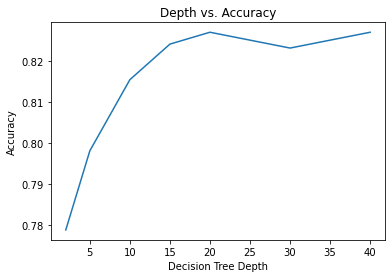

In [68]:
plt.plot(depths, accs)
plt.ylabel("Accuracy")
plt.xlabel("Decision Tree Depth")
plt.title("Depth vs. Accuracy")

In [9]:
clf = DecisionTree()
clf.fit(spam_data['training_data'], spam_data['training_labels'])

In [10]:
# 3.5.2
clf.tree.print2D(clf.tree)


                    ['leaf', 0]

          ['node', (19, 0.0)]

                              ['leaf', 0]

                    ['node', (31, 0.0)]

                              ['leaf', 1]

['node', (28, 0.0)]

                    ['leaf', 0]

          ['node', (19, 0.0)]

                              ['leaf', 0]

                    ['node', (29, 0.0)]

                              ['leaf', 0]


In [12]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        self.n = n
        self.m = m
        self.tree = [None for i in range(self.n)]
        self.max_depth = 7
    
    @staticmethod
    def entropy(y):
        # TODO implement entropy (or optionally gini impurity) function
        _, Counts = np.unique(y, return_counts = True)
        probs = Counts/Counts.sum()
        return sum((probs + eps)  * -np.log2(probs + eps))
    
    def child_entropy(self, left_data, right_data):
        total = len(left_data) + len(right_data)
        return len(left_data)/(total+eps) * self.entropy(left_data) + len(right_data)/(total+eps)*self.entropy(right_data)
    
    def split(self, X, y, idx, thresh):
        # TODO implement split function
        cont_left = X[:,idx] <= thresh
        cont_right = X[:, idx] > thresh
        left_data = X[cont_left]
        right_data = X[cont_right]
        left = y[cont_left]
        right = y[cont_right]
        return left_data, right_data, left, right

    def best_split(self, feature_col, y): # Caculate best split for one feature
        concatenated = np.c_[feature_col, y]
        sorted_mat = concatenated[concatenated[:, 0].argsort()]
        best_entropy, best_thresh = self.entropy(y), None 
        
        for thresh in sorted_mat[:,0]:
            _, _, left, right = self.split(sorted_mat, sorted_mat[:,-1], 0, thresh)
            child_entro = self.child_entropy(left, right)
            if (child_entro < best_entropy):
                best_entropy = child_entro
                best_thresh = thresh
        return best_entropy, best_thresh
    
    def pure(self, y):
        unique_classes,unique_class_count = np.unique(y,return_counts=True)
        if len(unique_classes) == 1:
            return True
        else:
            return False  
        
    def most(self, y) :
        unique_classes,unique_class_count = np.unique(y,return_counts=True)
        return unique_classes[unique_class_count.argmax()]
            
    def growTree(self, X, y, depth):
        if (self.pure(y)):
            return TreeNode(None, None, None, self.most(y))
        else:
            if depth == self.max_depth:
                return TreeNode(None, None, None, self.most(y))
            best_intro = self.entropy(y)
            best_thresh = None
            feature = None
            rng = np.random.default_rng(123)
            indices = rng.choice(len(X[0]), replace=False, size=self.m) 
            
            for idx in indices:
                entro, thresh = self.best_split(X[:,idx], y)
                if entro < best_intro: 
                    best_intro = entro
                    best_thresh = thresh
                    feature = idx
            # add back to the rest of the X
            if feature is None: # NO good feature    
                return TreeNode(None, None, None, self.most(y)) 
            left_data, right_data, left_y, right_y =self.split(X, y, feature, best_thresh)
            
            if len(left_data) == 0 or len(left_data[0]) == 0:
                return TreeNode((feature, best_thresh), TreeNode(None, None, None, self.most(y)), self.growTree(right_data, right_y, depth+1), None)
            elif len(right_data) == 0 or len(right_data[0]) == 0:
                 return TreeNode((feature, best_thresh), self.growTree(left_data, left_y, depth+1), TreeNode(None, None, None, self.most(y)), None)
            return TreeNode((feature, best_thresh), self.growTree(left_data, left_y, depth+1), self.growTree(right_data, right_y, depth+1), None)
            
    def fit(self, X, y):
        for idx in range(self.n):
            mask = np.random.choice(X.shape[0], X.shape[0], replace=True)
            bagged_X = X[mask]
            bagged_y = y[mask]
            decision_tree = self.growTree(bagged_X, bagged_y, 0)
            self.tree[idx] = decision_tree

    def predict(self, X):
        result = np.ones(X.shape[0])
        for idx in range(len(self.tree)):
            tree = self.tree[idx]
            vote = np.ones(X.shape[0])
            for i in range(X.shape[0]):
                vote[i] = tree.get_label(X[i])
            result += vote
        for idx in range(len(result)):
            if result[idx] >= (self.n)/2:
                result[idx] = 1
            else:
                result[idx] = 0
        return result

In [13]:
# Spam Random forest
clf = RandomForest(n=20, m = 16)

clf.fit(spam_train_data, spam_train_label)

validation = clf.predict(spam_val_data)
train = clf.predict(spam_train_data)
sum(validation == spam_val_label)/1035, sum(train == spam_train_label)/4137

(0.7507246376811594, 0.7655305777133188)

In [21]:
def preprocess(data):
    data['sex'].replace(['female', 'male'],[0, 1], inplace=True)
    data.drop(['ticket','cabin'], inplace=True, axis=1)
    
    #One hot encoding
    embark_dummies = pd.get_dummies(data.embarked)
    plass_dummies = pd.get_dummies(data.pclass)
    
    #Drop the original
    data = pd.concat([data, embark_dummies], axis='columns')
    data = pd.concat([data, plass_dummies], axis='columns')
    data.drop(['embarked'], inplace=True, axis=1)
    data.drop(['pclass'], inplace=True, axis=1)
    
    #Inference the Nan by median
    median_values=data[['sex','age','sibsp','parch','fare']].median()
    data[['sex','age','sibsp','parch','fare']] = data[['sex','age','sibsp','parch','fare']].fillna(value=median_values)
    return data

In [22]:
Training_Data_Path = 'datasets/titanic/titanic_training.csv'
Testing_Data_Path = 'datasets/titanic/titanic_testing_data.csv'

titanic_train_data = pd.read_csv(Training_Data_Path, header=0)
Testing_data = pd.read_csv(Testing_Data_Path, header=0)

titanic_train_data_processed = preprocess(titanic_train_data)
Testing_data_processed = preprocess(Testing_data)

In [23]:
titanic_train_data = titanic_train_data_processed.iloc[:,1:]
titanic_train_label = titanic_train_data_processed.iloc[:,0]

In [18]:
titanic_train_data_processed = titanic_train_data_processed.to_numpy()
titanic_test_data = Testing_data_processed.to_numpy()

In [19]:
titanic_data_zip = np.c_[titanic_train_data, titanic_train_label]
titanic_shuffled = np.random.permutation(titanic_data_zip)
titanic_train, titanic_val = titanic_shuffled[200:], titanic_shuffled[:200]
titanic_train_data, titanic_train_label = np.delete(titanic_train, 11, 1), titanic_train[:,11] #train data and label
titanic_val_data, titanic_val_label = np.delete(titanic_val, 11, 1), titanic_val[:,11] #val data and label
titanic_train_data.shape, titanic_train_label.shape, titanic_val_data.shape, titanic_val_label.shape

((799, 11), (799,), (200, 11), (200,))

In [99]:
# Titanic Decision Tree
clf = DecisionTree(max_depth=5)

In [100]:
clf.fit(titanic_train_data, titanic_train_label)

In [101]:
validation = clf.predict(titanic_val_data)
train = clf.predict(titanic_train_data)
sum(train == titanic_train_label)/(titanic_train_label.shape[0]), sum(validation == titanic_val_label)/(titanic_val_label.shape[0])

(0.83729662077597, 0.8)

In [79]:
#clf.tree.print2D(clf.tree)

In [80]:
## Titanic Random Forest
clf = RandomForest(n=100, m = 5)
clf.fit(titanic_train_data, titanic_train_label)
validation = clf.predict(titanic_val_data)
train = clf.predict(titanic_train_data)
sum(train == titanic_train_label)/(titanic_train_label.shape[0]), sum(validation == titanic_val_label)/(titanic_val_label.shape[0])

(0.7847309136420526, 0.825)

In [111]:
#3.6
clf = DecisionTree(max_depth=3)
clf.fit(titanic_train_data, titanic_train_label)
clf.tree.print2D(clf.tree)


                              ['leaf', 0.0]

                    ['node', (8, 0.0)]

                              ['leaf', 0.0]

          ['node', (1, 8.0)]

                              ['leaf', 0.0]

                    ['node', (2, 1.0)]

                              ['leaf', 1.0]

['node', (0, 0.0)]

                              ['leaf', 0.0]

                    ['node', (4, 23.25)]

                              ['leaf', 1.0]

          ['node', (10, 0.0)]

                              ['leaf', 1.0]

                    ['node', (7, 0.0)]

                              ['leaf', 1.0]
